## <center> **Livrable n°1 : Classification binaire** </center>

‎ 

Réalisé par le **groupe n°X** :
- GAURE Warren
- Membre n°2
- Membre n°3
- Membre n°4

‎

---


### **Sommaire**

1. [Mise en contexte](#contexte)
2. [Objectif du livrable](#objectif)
3. [Importation des bibliothèques](#import)
4. [Chargement et préparation des données](#load)
5. [Exploration et visualisation des données](#exploration)
6. [Configuration de l'environnement](#configuration)
7. [Choix de l'architecture](#architecture)
8. [Réalisation du modèle](#modele)
9. [Entraînement et évaluation du modèle](#train)
10. [Amélioration du modèle](#amelioration)
11. [Modèle final](#final)
12. [Conclusion](#conclusion)

‎ 

---

### 1. <a id='contexte'>Mise en contexte</a>

L’entreprise TouNum est spécialisée dans la numérisation de documents, qu’il s’agisse de textes ou d’images. Ses services sont particulièrement sollicités par des entreprises cherchant à transformer leur base documentaire papier en fichiers numériques exploitables. Aujourd’hui, TouNum souhaite aller plus loin en enrichissant son offre avec des outils basés sur le Machine Learning.

En effet, certains clients disposent d’un volume considérable de documents à numériser et expriment un besoin croissant pour des solutions de catégorisation automatique. Une telle innovation leur permettrait d’optimiser le traitement et l’exploitation de leurs données numérisées. Toutefois, TouNum ne dispose pas en interne des compétences nécessaires pour concevoir et mettre en place ces technologies.

C’est dans ce cadre que notre équipe de spécialistes en Data Science du CESI est sollicitée. Notre mission consiste à développer une première solution intégrant du captioning automatique : un système capable d’analyser des photographies et de générer une légende descriptive de manière autonome.

Heureusement, TouNum possède déjà plusieurs milliers d’images annotées, ce qui constituera une ressource précieuse pour entraîner les modèles de Machine Learning à partir d’un apprentissage supervisé.

---

### 2. <a id='objectif'>Objectif du livrable</a>

TouNum souhaite automatiser la sélection des photos destinées à l'annotation. Ce livrable propose une méthode de classification basée sur les réseaux de neurones pour filtrer les images qui ne sont pas des photos. La solution reposera sur l'architecture de réseau retenue en fonction des résultats obtenus.

---

### 3. <a id='import'>Importation des bibliothèques</a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight

---

### 4. <a id='load'>Chargement et préparation des données</a>

Nous allons maintenant charger et préparer les données fournies par TouNum.

Les images doivent être séparées en deux ensembles : l'un pour entraîner le modèle, l'autre pour l'évaluer.

In [3]:
dataset_directory = './dataset_livrable_1'
image_h = 180
image_w = 180
batch_s = 32

train_set = keras.utils.image_dataset_from_directory(
    dataset_directory,
    label_mode = "int",
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = 42,
    validation_split = 0.2,
    subset = "training"
)

test_set = keras.utils.image_dataset_from_directory(
    dataset_directory,
    label_mode = "int",
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = 42,
    validation_split = 0.2,
    subset = "validation",
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


La sortie indique la présence de **XXXX** fichiers au total, dont **XXXX** appartenant au jeu d'entraînement et **XXXX** au jeu de test.

Une fois les données réparties dans les deux ensembles, nous pouvons afficher le nom des labels.

In [4]:
class_names = train_set.class_names
print(f"Classes détectées : {class_names}")

Classes détectées : ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Notre jeu de données contient 5 catégories, mais nous cherchons simplement à distinguer les photos des autres images. Nous devons donc modifier les labels pour reformuler le problème en classification *binaire*.

In [5]:
photo_index = class_names.index('dandelion')

def binary_conversion(image, label):
    return image, tf.cast(tf.equal(label, photo_index), tf.int32)

train_set = train_set.map(binary_conversion)
test_set = test_set.map(binary_conversion)

for image, label in train_set.take(1):
    print(f"Labels après conversion : {label.numpy()}")

Labels après conversion : [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0]


Comme observé dans la sortie, la conversion est réussie et nous avons bien uniquement deux labels, `1` pour les photos et `0` pour les images qui ne sont pas des photos.

Après vérification des classes, nous devons nous assurer de la répartition équilibrée des données.

In [6]:
def print_class_distribution(dataset):
    nb_photos = sum(1 for _, label in dataset.unbatch() if label.numpy() == 1)
    nb_non_photos = sum(1 for _, label in dataset.unbatch() if label.numpy() == 0)
    total = nb_photos + nb_non_photos

    print(f"Nombre total d'images : {total}")
    print(f"Nombre de photos : {nb_photos} ({nb_photos/total*100:.2f}% du total)")
    print(f"Nombre de 'non-photos' : {nb_non_photos} ({nb_non_photos/total*100:.2f}% du total)")

In [7]:
print("------------------------- TRAIN SET -------------------------")
print_class_distribution(train_set)
print("------------------------- TEST SET --------------------------")
print_class_distribution(test_set)

------------------------- TRAIN SET -------------------------
Nombre total d'images : 2936
Nombre de photos : 707 (24.08% du total)
Nombre de 'non-photos' : 2229 (75.92% du total)
------------------------- TEST SET --------------------------
Nombre total d'images : 734
Nombre de photos : 191 (26.02% du total)
Nombre de 'non-photos' : 543 (73.98% du total)


La répartition des données est déséquilibrée dans les deux ensembles, avec une nette majorité d’images non-photographiques. Ce déséquilibre n’est pas un problème pour le set de test, car il permet d’évaluer le modèle dans des conditions réelles. En revanche, il peut nuire à l’apprentissage si le modèle est trop exposé à la classe majoritaire, ce qui pourrait créer un biais.

Pour atténuer l’impact du déséquilibre des classes dans l’ensemble d’entraînement, nous attribuons des poids différenciés aux classes lors de l’apprentissage. Cette méthode ne génère pas de nouvelles images et ne modifie pas la distribution des données, mais elle compense l’inéquité en pénalisant davantage le modèle lorsqu’il commet des erreurs sur la classe minoritaire.  

Les poids sont calculés automatiquement à l’aide de la fonction [`compute_class_weight()`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) de [`scikit-learn`](https://scikit-learn.org/stable/index.html), qui ajuste leur valeur en fonction de la fréquence des classes. Ainsi, le modèle apprend sans biais excessif en faveur de la classe majoritaire, tout en conservant un apprentissage équilibré.

In [8]:
classes = np.array([0, 1])

weights = compute_class_weight(
    class_weight = "balanced",
    classes = classes,
    y = np.array([label.numpy() for image, label in train_set.unbatch()])
)

class_weights = {0: weights[0], 1: weights[1]}

print(f"Poids des classes : {class_weights}")

Poids des classes : {0: np.float64(0.6585912965455362), 1: np.float64(2.0763790664780766)}


---

### 5. <a id='exploration'>Exploration et visualisation des données</a>

Une fois les données chargées et les labels modifiés, nous pouvons examiner plus en détail les images.

Nous affichons quelques images pour regarder plus en détail ce à quoi nous avons affaire.

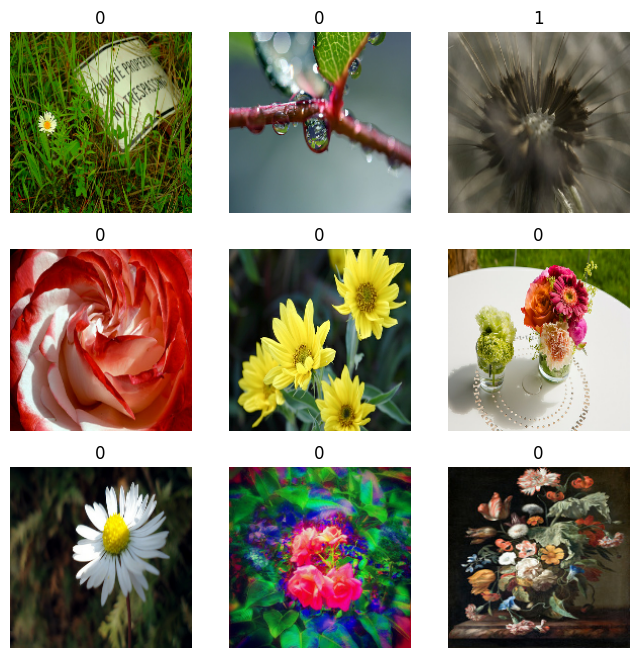

In [10]:
plt.figure(figsize = (8, 8))
for images, labels in train_set.take(10):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        plt.axis("off")

Enfin, nous affichons la taille des données, information pouvant être utile pour gérer les performances de notre modèle.

In [9]:
images, labels = next(iter(train_set.take(1)))
print(f"Tensor des images : {images.shape}")
print(f"Tensor des labels : {labels.shape}")

Tensor des images : (32, 180, 180, 3)
Tensor des labels : (32,)


---

### 6. <a id='configuration'>Configuration de l'environnement</a>

Pour optimiser les performances des calculs, nous allons configurer les données à l’aide de deux fonctions : `Dataset.cache` et `Dataset.prefetch`.  
- [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) stocke les données en mémoire pour éviter les accès répétés au disque.  
- [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) permet de traiter un élément en arrière-plan pendant l'entraînement ou l'évaluation.  

En combinant ces techniques, nous réduirons significativement le temps de traitement et la charge computationnelle.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size = AUTOTUNE)

---

### 7. <a id='architecture'>Choix de l'architecture</a>

Nous avons choisi une architecture basée sur les **réseaux de neurones convolutifs (CNN)**, particulièrement adaptés à la classification binaire d’images. Contrairement aux réseaux classiques (MLP), qui traitent chaque pixel indépendamment, les CNN exploitent les relations entre pixels pour mieux détecter les motifs et les formes. Grâce à leurs **filtres partagés**, ils réduisent considérablement le nombre de paramètres, rendant l’entraînement plus rapide et limitant le surapprentissage. Ces propriétés en font une solution puissante et efficace pour notre problème.

---

### 8. <a id='modele'>Réalisation du modèle</a>

Maintenant que le choix de l'architecture est fait, nous pouvons commencer à créer le modèle que nous allons utiliser pour classifier les images envoyées par l'entreprise.

Notre modèle sera structuré autour des blocs suivants :  
- Une **couche de rescaling** pour normaliser les valeurs des composantes RGB des pixels dans l'intervalle `[0;1]`.  
- Une **première convolution** avec 16 filtres de taille 3x3 (`Conv2D`), suivie d'un **max pooling** pour réduire la dimension spatiale.  
- Une **seconde convolution** utilisant 32 filtres de taille 3x3.  
- Une **troisième convolution** avec 64 filtres de taille 3x3.  
- Une **transformation en vecteur** via une opération d'aplatissement (`Flatten`).  
- Une **couche dense** de 128 unités pour capturer les caractéristiques extraites.  
- Enfin, une **sortie entièrement connectée** avec 1 unité, correspondant à la classe cible.  

In [12]:
num_classes = 1

model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes, activation = 'sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

L'optimiseur [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) est choisi pour sa capacité d'adaptation et sa rapidité de convergence, combinant les avantages de [`Momentum`](https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/MomentumOptimizer) et [`RMSprop`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop).

La fonction de perte [`BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) est utilisée car elle est plus efficace en mémoire et bien adaptée à la classification binaire.

Le code suivant va permettre d'avoir un résumé du modèle tel qu'il est à ce stade.

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

---

### 9. <a id='train'>Entraînement et évaluation du modèle</a>

Avec le modèle créé, nous pouvons désormais procéder à son entraînement et son évaluation avec les ensembles de données à notre disposition.

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 846ms/step - accuracy: 0.6120 - loss: 2.6636 - val_accuracy: 0.7520 - val_loss: 0.4728
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 71s 767ms/step - accuracy: 0.7342 - loss: 0.5028 - val_accuracy: 0.6621 - val_loss: 0.6025
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 803ms/step - accuracy: 0.8179 - loss: 0.3837 - val_accuracy: 0.8338 - val_loss: 0.4013
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 766ms/step - accuracy: 0.8550 - loss: 0.3136 - val_accuracy: 0.8515 - val_loss: 0.3799
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 71s 772ms/step - accuracy: 0.9554 - loss: 0.1447 - val_accuracy: 0.8542 - val_loss: 0.4632
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 748ms/step - accuracy: 0.9724 - loss: 0.0855 - val_accuracy: 0.8202 - val_loss: 0.6919
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 743ms/step - accuracy: 0.9854 - loss: 0.0374 - val_accuracy: 0.7711 - val_loss: 1.0584
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 751ms/step - accuracy: 0.9935 - loss: 0.0175 - val_accu

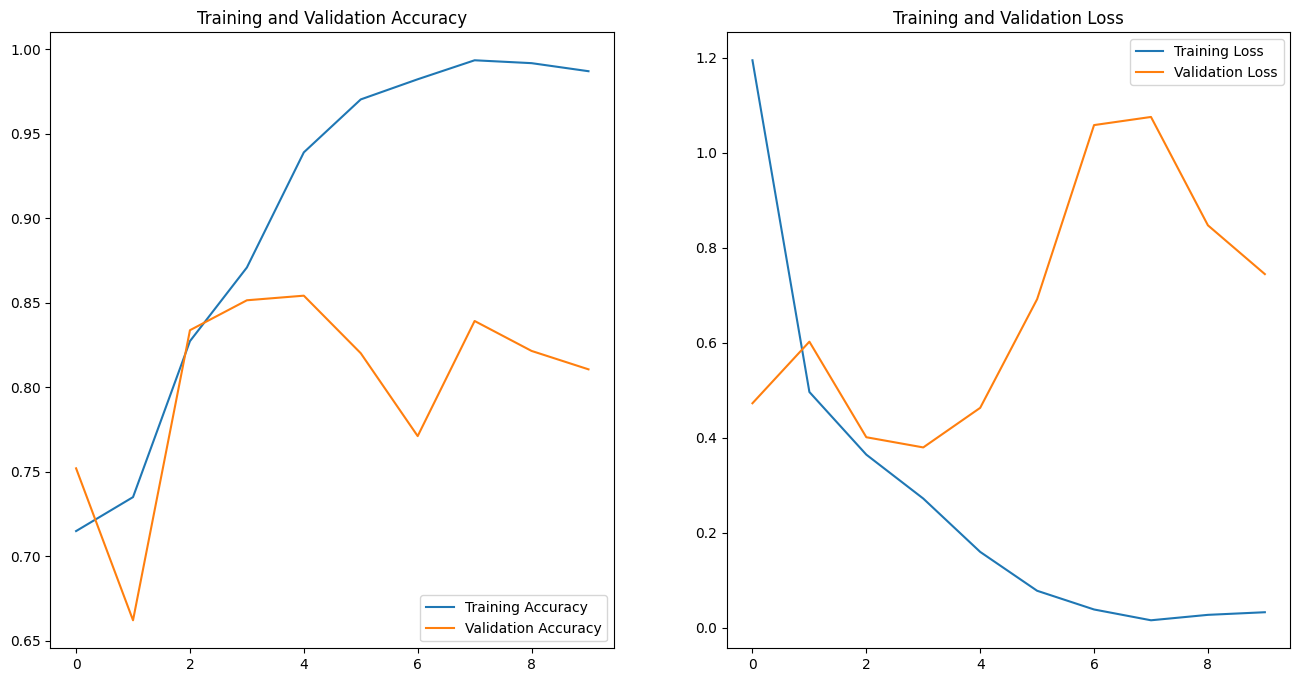

In [15]:
epochs = 10
epochs_range = range(epochs)

history = model.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs,
    class_weight = class_weights
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats et parler du sur-apprentissage ainsi que de la potentielle instabilité.

---

### 10. <a id='amelioration'>Amélioration du modèle</a>

Afin de palier au surapprentissage observé et d’améliorer la généralisation du modèle, plusieurs techniques de régularisation ont été retenues :

- [**Data Augmentation**](#augmentation): Cette technique consister à générer artificiellement de nouvelles images en appliquant des transformations aléatoires aux données existantes. Elle permet d'améliorer la généralisation du modèle en le rendant plus robuste aux variations comme l’orientation, la luminosité ou le zoom.

- [**Dropout**](#dropout) : Cette méthode consiste à désactiver aléatoirement un certain pourcentage de neurones à chaque itération lors de l'entraînement. Cela empêche le modèle de devenir trop dépendant de certaines connexions et encourage l'apprentissage de représentations plus robustes. Une valeur typique se situe entre 0.2 et 0.5 selon la complexité du réseau.

- [**Early-Stopping**](#early-stopping) : Cette technique permet d'arrêter automatiquement l'entraînement lorsque la performance sur l’ensemble de validation commence à se dégrader. Elle évite d’entraîner le modèle trop longtemps, ce qui pourrait mener à un surajustement aux données d’entraînement. Un paramètre clé est la `patience`, qui définit le nombre d’époques d'attente avant d'interrompre l'entraînement si aucune amélioration n'est observée.

- [**Régularisation L1 (Lasso)**](#l1) : L1 applique une pénalité sur la somme des valeurs absolues des poids du modèle. Cela pousse certains poids à devenir exactement nuls, ce qui permet une sparsité dans les connexions et peut aider à réduire l'impact des variables les moins importantes. Elle est particulièrement utile pour éliminer les caractéristiques inutiles dans des modèles fortement paramétrés.

- [**Régularisation L2 (Ridge)**](#l2) : L2 impose une pénalité sur la somme des carrés des poids, ce qui réduit la magnitude des paramètres sans les annuler complètement. Cela permet de contrôler des valeurs extrêmes qui pourraient rendre le modèle trop sensible aux fluctuations des données d’entraînement. Cette méthode est couramment utilisée dans les réseaux convolutifs, où il est essentiel d'éviter des poids trop dominants.

En testant et, potentiellement, combinant ces différentes approches, nous parviendrons à obtenir un modèle plus stable, robuste, et capable de mieux généraliser sur des données non vues.

──────────────────────────────────────────────────

#### 10.1. <a id='augmentation'>Data Augmentation</a>

Pour cette approche, nous allons appliquer des transformations aux données d'entraînement, comme un retournement aléatoire, une rotation de 10% et d’un zoom vertical de 10%. Les données de test restent inchangées pour permettre au modèle de pouvoir faire des prédictions sur un cas réel.

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(input_shape = (image_h, image_w, 3), mode = 'horizontal_and_vertical'),
    layers.RandomRotation(factor = 0.1, fill_mode = 'nearest'),
    layers.RandomZoom(height_factor = 0.1, fill_mode = 'nearest'),
])

train_set_augmented = train_set.map(lambda x, y: (data_augmentation(x, training = True), y))

c:\Users\Utilisateur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_with_augmentation = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes, activation = 'sigmoid')
])

model_with_augmentation.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

model_with_augmentation.summary()

c:\Users\Utilisateur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Nous pouvons procéder à l'entraînement de cette version du modèle.

Epoch 1/10


92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 831ms/step - accuracy: 0.6478 - loss: 2.9449 - val_accuracy: 0.5790 - val_loss: 0.6023
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 833ms/step - accuracy: 0.6509 - loss: 0.5953 - val_accuracy: 0.7466 - val_loss: 0.5002
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 830ms/step - accuracy: 0.6982 - loss: 0.5091 - val_accuracy: 0.7629 - val_loss: 0.5040
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 78s 846ms/step - accuracy: 0.7536 - loss: 0.4749 - val_accuracy: 0.8202 - val_loss: 0.4338
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 823ms/step - accuracy: 0.7835 - loss: 0.4232 - val_accuracy: 0.8079 - val_loss: 0.4462
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 824ms/step - accuracy: 0.8083 - loss: 0.3994 - val_accuracy: 0.8106 - val_loss: 0.4261
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 825ms/step - accuracy: 0.8085 - loss: 0.4306 - val_accuracy: 0.8079 - val_loss: 0.4281
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 824ms/step - accuracy: 0.8158 - loss: 0.3719 - val_accuracy: 0.779

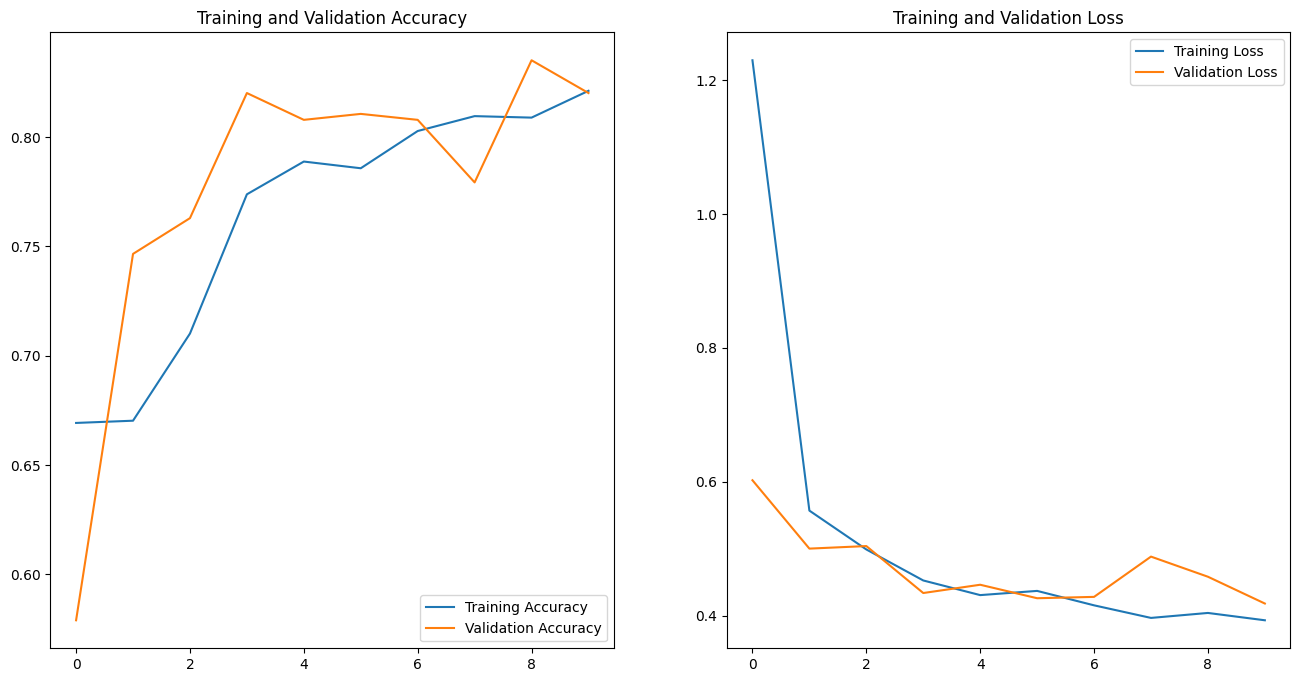

In [ ]:
epochs = 10
epochs_range = range(epochs)

history = model_with_augmentation.fit(
    train_set_augmented,
    validation_data = test_set,
    epochs = epochs,
    class_weight = class_weights
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

&nbsp;

**Notes lors des tests**
- Méthode efficace pour gérer le surapprentissage
- Les courbes d'accuracy augmentent ensemble de manière cohérente
- Pas de divergence apparente
- Très bonne capacité de généralisation vu que la courbe de Validation Accuracy est souvent au-dessus de celle de la Training Accuracy

──────────────────────────────────────────────────

#### 10.2. <a id='dropout'>Dropout</a>

Pour cette approche, nous ajoutons un Dropout de 25% après le MaxPooling et un Dropout de 50% après la couche Dense, en s'inspirant de l’approche de [Keras pour le dataset MNIST](https://github.com/keras-team/keras/blob/keras-2/examples/mnist_cnn.py). Le premier limite la dépendance aux caractéristiques extraites, tandis que le second réduit le surajustement dans la partie dense.

In [20]:
model_with_dropout = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = 'sigmoid')
])

model_with_dropout.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

model_with_dropout.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Nous pouvons procéder à l'entraînement de cette version du modèle.

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 883ms/step - accuracy: 0.6664 - loss: 2.1129 - val_accuracy: 0.5259 - val_loss: 0.6153
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 813ms/step - accuracy: 0.7238 - loss: 0.5488 - val_accuracy: 0.6880 - val_loss: 0.5041
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 809ms/step - accuracy: 0.7516 - loss: 0.4930 - val_accuracy: 0.7371 - val_loss: 0.4623
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 808ms/step - accuracy: 0.7546 - loss: 0.4767 - val_accuracy: 0.6785 - val_loss: 0.5431
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 78s 851ms/step - accuracy: 0.8064 - loss: 0.3848 - val_accuracy: 0.6921 - val_loss: 0.5670
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 884ms/step - accuracy: 0.8392 - loss: 0.3124 - val_accuracy: 0.7153 - val_loss: 0.5895
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 885ms/step - accuracy: 0.8795 - loss: 0.2461 - val_accuracy: 0.8038 - val_loss: 0.5517
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 880ms/step - accuracy: 0.9228 - loss: 0.1858 - val_accu

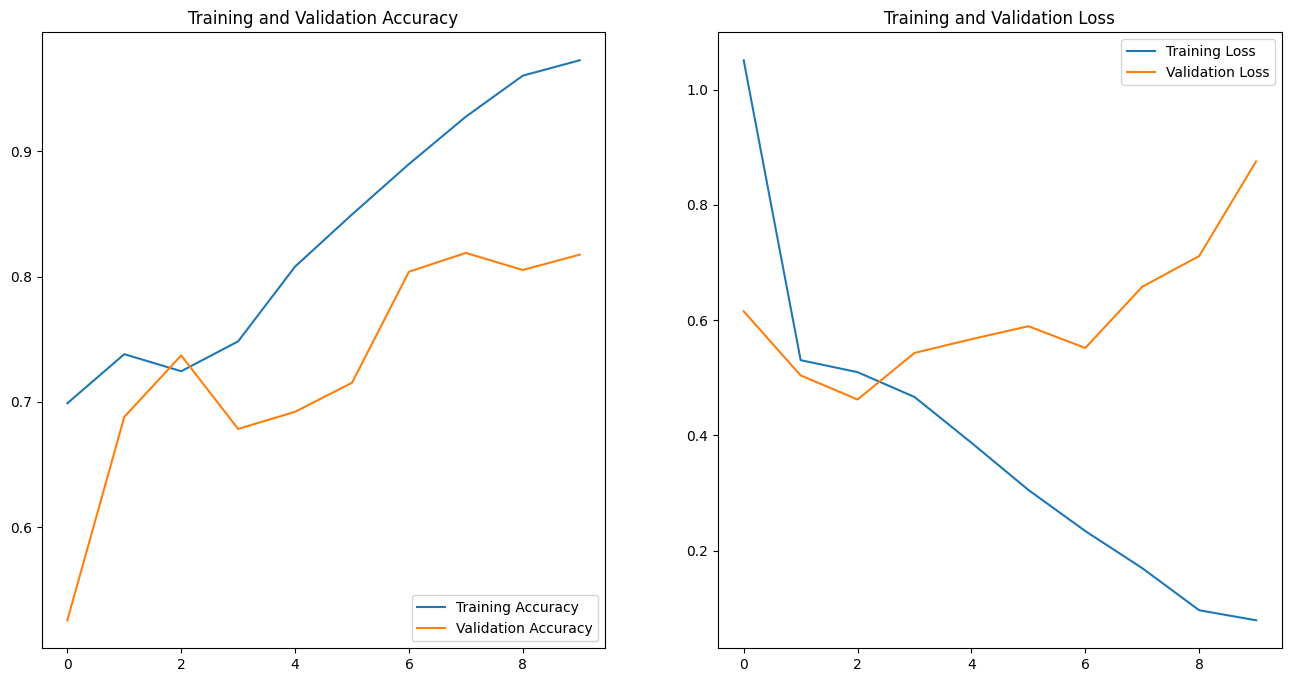

In [21]:
epochs = 10
epochs_range = range(epochs)

history = model_with_dropout.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs,
    class_weight = class_weights
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

&nbsp;

**Notes lors des tests**
- Apprend trop vite (Traning Accuracy > 95%) mais ne généralise pas mieux pour autant (Validation Loss en hausse)
- La Validation Accuracy se stabilise au bout de la 6ème époque
- Écart significatif entre la Traning Accuracy et la Validation Accuracy => surapprentissage
- Le Dropout seul semble ne pas suffire

──────────────────────────────────────────────────

#### 10.3. <a id='early-stopping'>Early Stopping</a>

Pour cette approche, nous ajoutons un Early Stopping basé sur la perte de validation, avec une patience de 5 époques, afin d’interrompre l’entraînement dès que le modèle cesse de s’améliorer et de conserver les meilleurs poids.

In [15]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 2,
    mode = 'max',
    restore_best_weights = True
)

In [26]:
model_with_early_stopping = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes, activation = 'sigmoid')
])

model_with_early_stopping.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

model_with_early_stopping.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Nous pouvons procéder à l'entraînement de cette version du modèle.

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 834ms/step - accuracy: 0.6153 - loss: 4.8739 - val_accuracy: 0.7112 - val_loss: 0.5213
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 827ms/step - accuracy: 0.6891 - loss: 0.5657 - val_accuracy: 0.7221 - val_loss: 0.5140
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 828ms/step - accuracy: 0.7956 - loss: 0.3815 - val_accuracy: 0.7153 - val_loss: 0.5793
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 821ms/step - accuracy: 0.8946 - loss: 0.2560 - val_accuracy: 0.7943 - val_loss: 0.4605
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 815ms/step - accuracy: 0.9453 - loss: 0.1496 - val_accuracy: 0.7779 - val_loss: 0.6678
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 822ms/step - accuracy: 0.9649 - loss: 0.0939 - val_accuracy: 0.8120 - val_loss: 0.7502
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 839ms/step - accuracy: 0.9842 - loss: 0.0544 - val_accuracy: 0.7997 - val_loss: 1.0211
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 827ms/step - accuracy: 0.9916 - loss: 0.0257 - val_accu

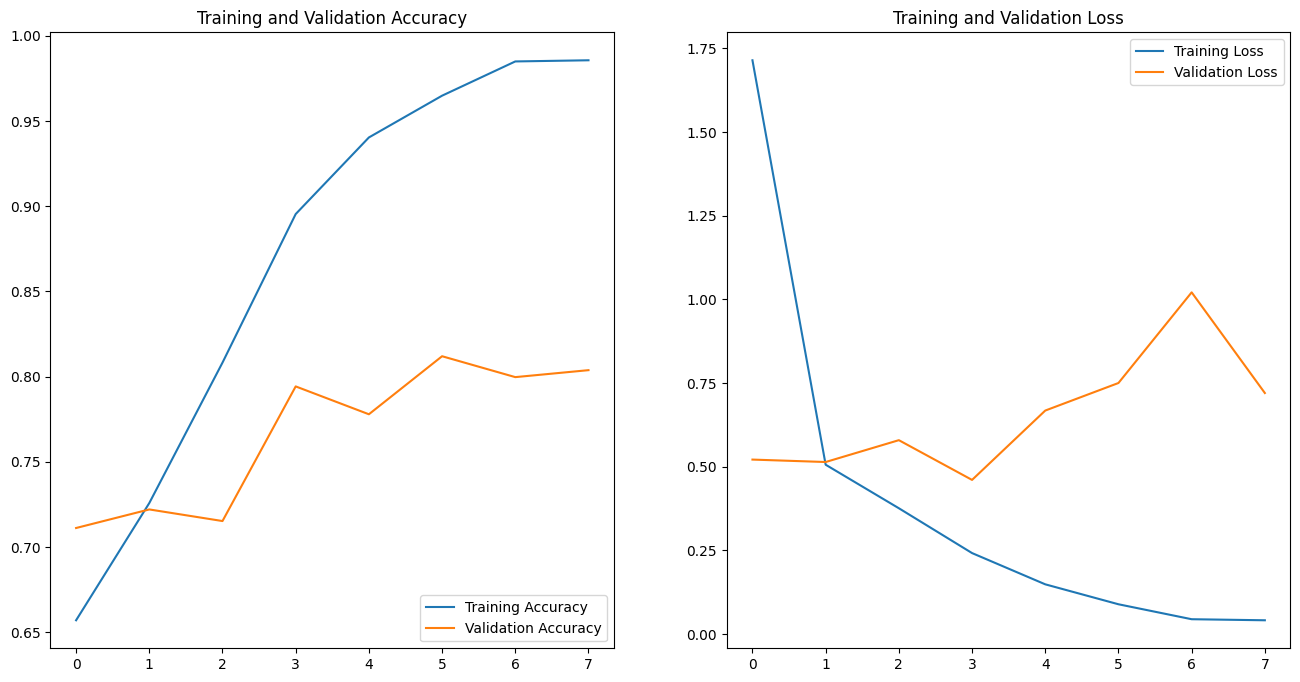

In [27]:
epochs = 20

history = model_with_early_stopping.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs,
    callbacks = [early_stopping],
    class_weight = class_weights
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs_range = range(len(accuracy))

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

&nbsp;

**Notes lors des tests**
- Apprend trop vite (Traning Accuracy > 95%) mais ne généralise pas mieux pour autant
- Traning Accuracy proche de 100% à la fin + écart avec Validation Accuracy => surapprentissage
- La Validation Loss augmente, ce qui est un autre signe du surapprentissage
- Méthode insuffisante à elle seule pour prévenir l'overfitting

──────────────────────────────────────────────────

#### 10.4. <a id='l1'>Régularisation L1 (Lasso)</a>

Nous allons appliquer une régularisation L1 pour limiter la complexité du modèle en forçant certains poids à devenir exactement nuls.

In [20]:
model_with_l1 = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu', kernel_regularizer = keras.regularizers.l1(1e-5)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', kernel_regularizer = keras.regularizers.l1(1e-5)),
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu', kernel_regularizer = keras.regularizers.l1(1e-5)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu', kernel_regularizer = keras.regularizers.l1(1e-5)),
    layers.Dense(num_classes, activation = 'sigmoid')
])

model_with_l1.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

model_with_l1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Nous pouvons procéder à l'entraînement de cette version du modèle.

Epoch 1/10


92/92 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5924 - loss: 2.9775 - val_accuracy: 0.7507 - val_loss: 0.9298
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7571 - loss: 0.8851 - val_accuracy: 0.8324 - val_loss: 0.6781
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8468 - loss: 0.6196 - val_accuracy: 0.8420 - val_loss: 0.6459
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8790 - loss: 0.5615 - val_accuracy: 0.7520 - val_loss: 0.7419
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9187 - loss: 0.4476 - val_accuracy: 0.7834 - val_loss: 0.7825
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9293 - loss: 0.4168 - val_accuracy: 0.8256 - val_loss: 0.7915
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9477 - loss: 0.4137 - val_accuracy: 0.7943 - val_loss: 0.9016
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9607 - loss: 0.3693 - val_accuracy: 0.7929 - val_loss: 0.8819
Ep

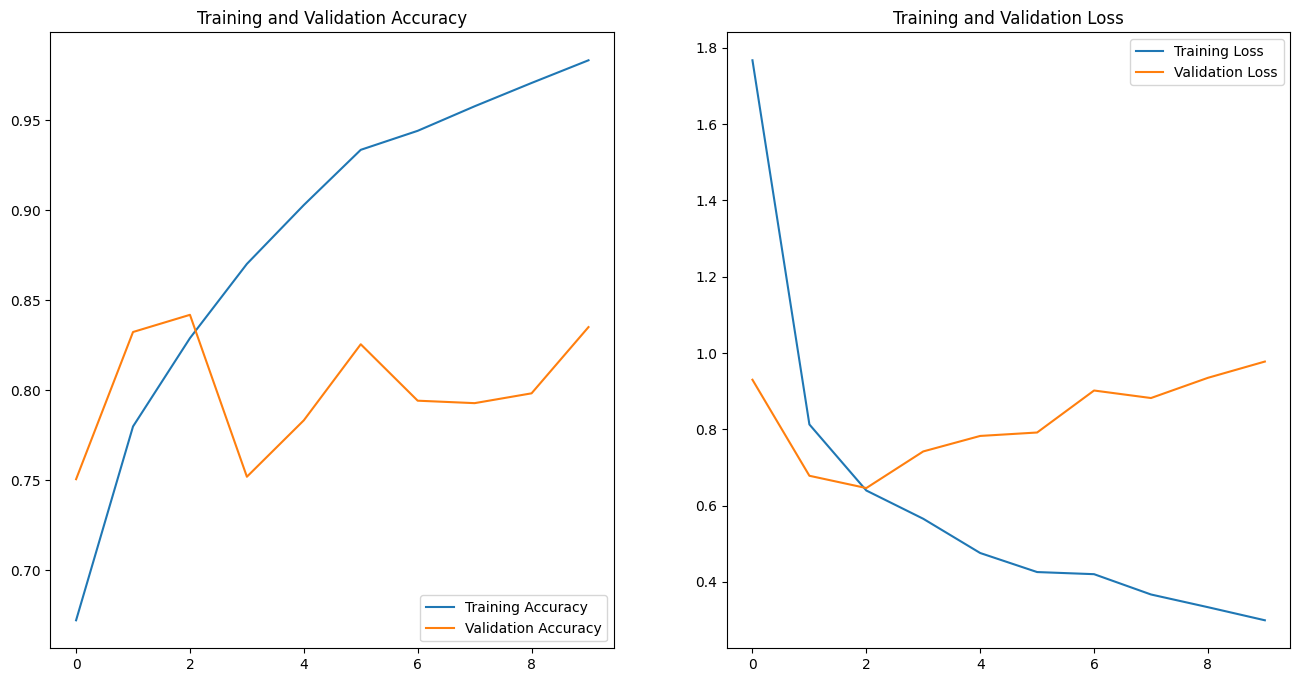

In [21]:
epochs = 10
epochs_range = range(epochs)

history = model_with_l1.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs,
    class_weight = class_weights
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

&nbsp;

**Notes lors des tests**
- Apprend trop vite (Traning Accuracy > 95%) mais ne généralise pas mieux pour autant
- Traning Accuracy proche de 100% à la fin + écart avec Validation Accuracy => surapprentissage
- La Validation Loss augmente, ce qui est un autre signe du surapprentissage
- Méthode insuffisante à elle seule pour prévenir l'overfitting (peut donner lieu à une combinaison avec L2)

──────────────────────────────────────────────────

#### 10.5. <a id='l2'>Régularisation L2 (Ridge)</a>

Nous allons maintenant appliquer une régularisation L2 (Ridge) afin de réduire la magnitude des poids sans les annuler complètement.

In [22]:
model_with_l2 = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(2e-4)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(2e-4)),
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(2e-4)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu', kernel_regularizer = keras.regularizers.l2(2e-4)),
    layers.Dense(num_classes, activation = 'sigmoid')
])

model_with_l2.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

model_with_l2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Nous pouvons procéder à l'entraînement de cette version du modèle.

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 996ms/step - accuracy: 0.5070 - loss: 2.1381 - val_accuracy: 0.6880 - val_loss: 0.7178
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7078 - loss: 0.6822 - val_accuracy: 0.7139 - val_loss: 0.5873
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.7654 - loss: 0.5608 - val_accuracy: 0.6757 - val_loss: 0.6475
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8304 - loss: 0.4596 - val_accuracy: 0.5436 - val_loss: 0.9453
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8333 - loss: 0.4661 - val_accuracy: 0.7875 - val_loss: 0.6377
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9166 - loss: 0.3208 - val_accuracy: 0.7698 - val_loss: 0.6560
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9465 - loss: 0.2562 - val_accuracy: 0.8011 - val_loss: 0.7842
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9620 - loss: 0.2268 - val_accuracy: 0.8134 - val_lo

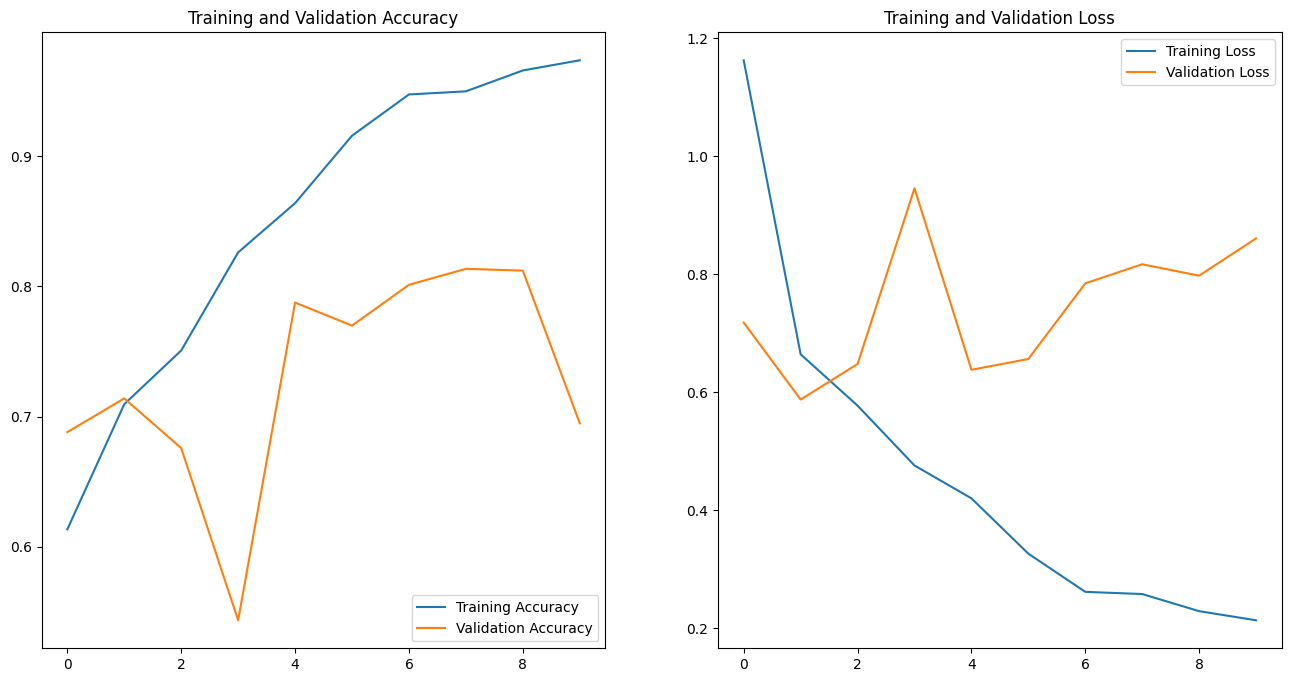

In [23]:
epochs = 10
epochs_range = range(epochs)

history = model_with_l2.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs,
    class_weight = class_weights
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

&nbsp;

**Notes lors des tests**
- Training Accuracy montre que le modèle apprend bien (peut-être même trop bien)
- Stabilité de Validation Accuracy
- La Validation Loss augmentant est un signe de surapprentissage

──────────────────────────────────────────────────

#### 10.6. Data Augmentation & Dropout

Nous combinons ici Data Augmentation et Dropout afin de tester leur impact conjoint sur la régularisation du modèle.

In [25]:
model_with_augmentation_dropout = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = 'sigmoid')
])

model_with_augmentation_dropout.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

model_with_augmentation_dropout.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Nous pouvons procéder à l'entraînement de cette version du modèle.

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 78s 822ms/step - accuracy: 0.6242 - loss: 1.7093 - val_accuracy: 0.2970 - val_loss: 0.7296
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 813ms/step - accuracy: 0.6256 - loss: 0.5926 - val_accuracy: 0.7766 - val_loss: 0.5105
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 812ms/step - accuracy: 0.6791 - loss: 0.5422 - val_accuracy: 0.7888 - val_loss: 0.4955
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 806ms/step - accuracy: 0.7312 - loss: 0.5073 - val_accuracy: 0.7629 - val_loss: 0.4525
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 817ms/step - accuracy: 0.7208 - loss: 0.4535 - val_accuracy: 0.7589 - val_loss: 0.4961
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 812ms/step - accuracy: 0.7199 - loss: 0.4907 - val_accuracy: 0.7834 - val_loss: 0.4141
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 818ms/step - accuracy: 0.6839 - loss: 0.5773 - val_accuracy: 0.7480 - val_loss: 0.4833
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7339 - loss: 0.4848 - val_accura

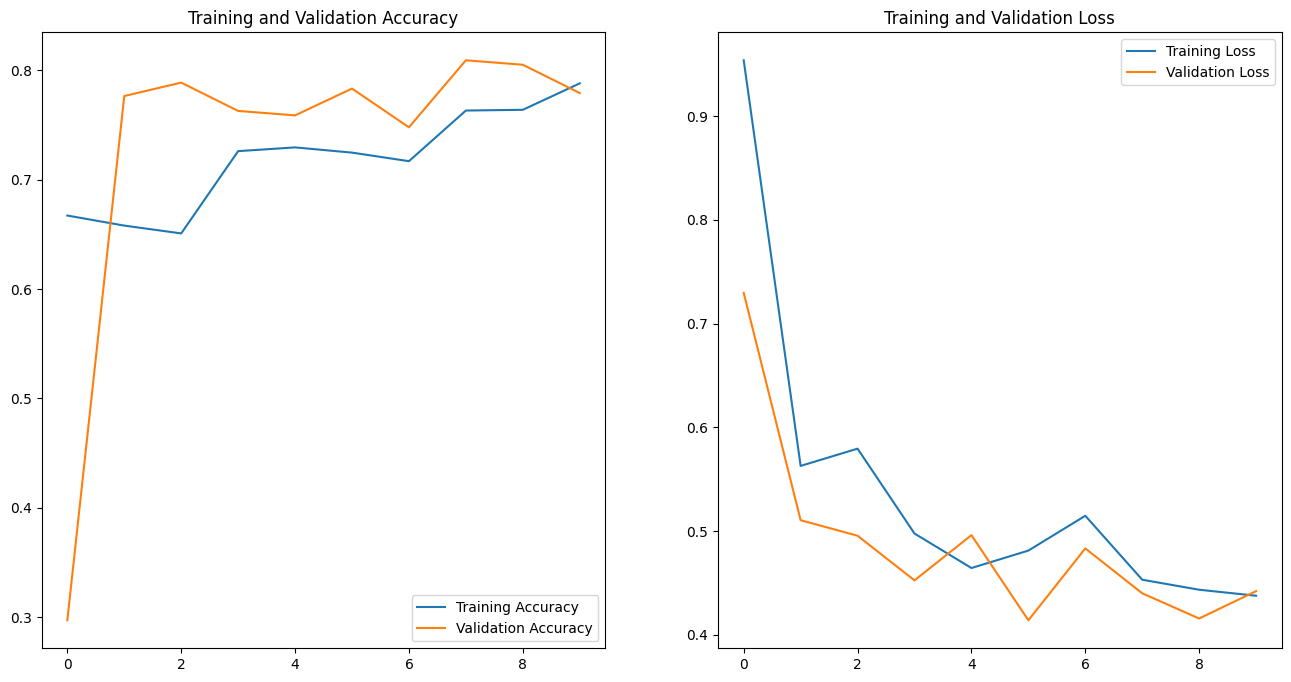

In [26]:
epochs = 10
epochs_range = range(epochs)

history = model_with_augmentation_dropout.fit(
    train_set_augmented,
    validation_data = test_set,
    epochs = epochs,
    class_weight = class_weights
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

&nbsp;

**Notes lors des tests**
- Très très bons résultats
- Apprentissage stable et aucune trace d'overfitting
- Absence de "bruits" (pics dans les graphiques) donc régularisation efficace
- **À garder !**

──────────────────────────────────────────────────

#### 10.7. Data Augmentation & Early Stopping

Nous combinons ici Data Augmentation et Early Stopping afin de tester leur impact conjoint sur la régularisation du modèle.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

model_with_augmentation_stopping = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes, activation = 'sigmoid')
])

model_with_augmentation_stopping.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

model_with_augmentation_stopping.summary()


Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
epochs = 20

history = model_with_augmentation_stopping.fit(
    train_set_augmented,
    validation_data = test_set,
    epochs = epochs,
    callbacks = [early_stopping],
    class_weight = class_weights
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs_range = range(len(accuracy))

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

──────────────────────────────────────────────────

#### 10.8. Dropout & Early Stopping

Nous combinons ici Dropout et Early Stopping afin de tester leur impact conjoint sur la régularisation du modèle.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

model_with_dropout_stopping = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = 'sigmoid')
])

model_with_dropout_stopping.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

model_with_dropout_stopping.summary()

Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
epochs = 20

history = model_with_dropout_stopping.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs,
    callbacks = [early_stopping],
    class_weight = class_weights
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs_range = range(len(accuracy))

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

──────────────────────────────────────────────────

#### 10.9. Elastic Net (L1 + L2)

Nous allons maintenant tester [Elastic Net](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L1L2), qui combine les avantages de L1 (Lasso) et L2 (Ridge). Cette régularisation permet à la fois de forcer certains poids à zéro (effet L1) et de réduire la magnitude des autres (effet L2), ce qui équilibre la simplification du modèle et sa stabilité.

In [ ]:
model_with_elasticnet = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu', kernel_regularizer = keras.regularizers.l1_l2(1e-5, 1e-4)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', kernel_regularizer = keras.regularizers.l1_l2(1e-5, 1e-4)),
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu', kernel_regularizer = keras.regularizers.l1_l2(1e-5, 1e-4)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu', kernel_regularizer = keras.regularizers.l1_l2(1e-5, 1e-4)),
    layers.Dense(num_classes, activation = 'sigmoid')
])

model_with_elasticnet.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

model_with_elasticnet.summary()

Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
epochs = 10
epochs_range = range(epochs)

history = model_with_elasticnet.fit(
    train_set,
    validation_data = test_set,
    epochs = epochs,
    class_weight = class_weights
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

──────────────────────────────────────────────────

#### 10.10. Data Augmentation, Dropout & Early Stopping

Nous combinons ici Data Augmentation, Dropout et Early Stopping afin de tester leur impact conjoint sur la régularisation du modèle.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

model_with_augmentation_dropout_stopping = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = 'sigmoid')
])

model_with_augmentation_dropout_stopping.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

model_with_augmentation_dropout_stopping.summary()

Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
epochs = 20

history = model_with_augmentation_dropout_stopping.fit(
    train_set_augmented,
    validation_data = test_set,
    epochs = epochs,
    callbacks = [early_stopping],
    class_weight = class_weights
)

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs_range = range(len(accuracy))

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

---

### 11. <a id='final'>Modèle final</a>

<b style="color:yellow;">TODO</b>

Indiquer et justifier le choix du modèle final à l'aide des résultats observés. Faire la passe sur ses caractéristiques, à savoir :
- Paramètres
- Fonction de perte
- Algorithme d'optimisation utilisé pour l'entraînement

Inclure un schéma du modèle réalisé grâce à cet [outil](https://alexlenail.me/NN-SVG/LeNet.html).

---

### 12. <a id='conclusion'>Conclusion</a>

<b style="color:yellow;">TODO</b>

Écrire la conclusion.

---